## Stocks Trading Strategy Based on Daily Price Change - Multiple Stocks
This strategy is to :
1. Buy one share of certain stocks in a predefined portfolio if the stocks price falls more than a certain percentage (pct change of closing price)
2. Hold all the shares till today
3. Evaluate the gain or loss.

## Disclaimer : 
This is again a dumbass strategy and I'm not recommending anyone to follow it, this whole notebook is just a toy.

### 1. First thing first, import necessary libraries, some may not be used though...

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance
import quandl 
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

### 2. Get the stocks price data and work with it

In [35]:
def get_data(tickers, startdate, enddate):
    data = pdr.DataReader(tickers, 'yahoo', start=startdate, end=enddate)
    return data

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get_data(tickers, datetime.datetime(2020,1,2), datetime.date.today()).stack().reset_index()

In [36]:
all_data.head()

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume
0,2020-01-02,AAPL,74.096443,75.087502,75.150002,73.797501,74.059998,135480400.0
1,2020-01-02,MSFT,157.903488,160.619995,160.729996,158.330002,158.779999,22622100.0
2,2020-01-02,IBM,124.142937,135.419998,135.919998,134.770004,135.000000,3148600.0
3,2020-01-02,GOOG,1367.369995,1367.369995,1368.140015,1341.550049,1341.550049,1406600.0
4,2020-01-03,AAPL,73.376083,74.357498,75.144997,74.125000,74.287498,146322800.0


In [37]:
all_data.tail()

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume
1659,2021-08-24,GOOG,2847.969971,2847.969971,2860.149902,2827.070068,2830.870117,756300.0
1660,2021-08-25,AAPL,148.360001,148.360001,150.320007,147.800003,149.809998,58924000.0
1661,2021-08-25,MSFT,302.010010,302.010010,304.589996,300.420013,304.299988,19999400.0
1662,2021-08-25,IBM,139.860001,139.860001,140.800003,139.460007,139.919998,2012100.0
1663,2021-08-25,GOOG,2859.000000,2859.000000,2866.260010,2848.790039,2857.659912,641900.0


In [38]:
all_data['Ytd Close'] = all_data.Close.shift(len(tickers)) # shift by how many tickers we are analyzing
all_data['Diff'] = all_data.Close - all_data['Ytd Close']
all_data['Closing Price Pct Change'] = all_data.Close.pct_change(len(tickers)) # daily price percentage change
# data = data.iloc[1:, :] # remove the first row
all_data.head()

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,Ytd Close,Diff,Closing Price Pct Change
0,2020-01-02,AAPL,74.096443,75.087502,75.150002,73.797501,74.059998,135480400.0,NaN,NaN,NaN
1,2020-01-02,MSFT,157.903488,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN
2,2020-01-02,IBM,124.142937,135.419998,135.919998,134.770004,135.000000,3148600.0,NaN,NaN,NaN
3,2020-01-02,GOOG,1367.369995,1367.369995,1368.140015,1341.550049,1341.550049,1406600.0,NaN,NaN,NaN
4,2020-01-03,AAPL,73.376083,74.357498,75.144997,74.125000,74.287498,146322800.0,75.087502,-0.730003,-0.009722


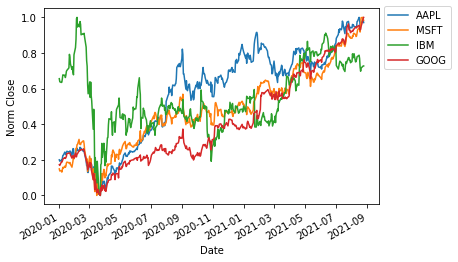

In [39]:
# create a normalized closing price column so we can prepare different stocks
grouper = all_data.groupby('Symbols')['Close']
maxes = grouper.transform('max')
mins = grouper.transform('min')
all_data['Norm Close'] = (all_data.Close - mins)/(maxes - mins)

# plot the closing price
closeplot = sns.lineplot(data=all_data, x='Date', y='Norm Close', hue='Symbols')
closeplot.get_figure().autofmt_xdate()
closeplot.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1);

,count,mean,std,min,25%,50%,75%,max
Symbols,,,,,,,,
AAPL,415.0,0.001957,0.025104,-0.128647,-0.009183,0.001255,0.014627,0.119808
GOOG,415.0,0.002001,0.021105,-0.111008,-0.006190,0.003021,0.011320,0.094017
IBM,415.0,0.000324,0.022103,-0.128507,-0.008522,0.000730,0.009374,0.113011
MSFT,415.0,0.001788,0.023045,-0.147390,-0.008617,0.001484,0.012336,0.142169


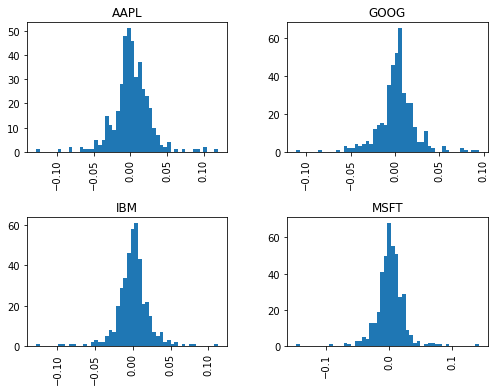

In [40]:
# Plot the distribution of 'Percentage Price Change'
all_data['Closing Price Pct Change'].hist(by=all_data['Symbols'], bins=50, figsize=(8,6))

# Pull up summary statistics table
all_data.groupby('Symbols')['Closing Price Pct Change'].describe()

### 3. Let's create some helper functions before implementing the trading strategy

In [41]:
def pct_change(buy, sell):
    return (sell - buy) / buy

In [42]:
def mean(value, n):
    return value / n

### 4. The signal function

In [43]:
# produce a signal when to buy or sell the stocks
def signal(pct_change):
    if pct_change < -0.05: # choose a benchmark fall percentage
        return 'Buy'

### 5. Implement the strategy

In [44]:
mydate = []
mysymbols = []
mypctchange = []
myshares = []
mytotalshares = []
mybuyingprice = []
mytotalcost = []

for i, row in all_data.iterrows():
    if signal(row['Closing Price Pct Change']) == 'Buy':
        mydate.append(row.Date)
        mysymbols.append(row.Symbols)
        mypctchange.append(row['Closing Price Pct Change'])
        myshares.append(1)
        mytotalshares.append(sum(myshares))
        mybuyingprice.append(row['Open'])
        mytotalcost.append(sum(mybuyingprice))

# create my shares purchasing df
mydf = pd.DataFrame({'Date': mydate,
                     'Symbols': mysymbols,
                     'Closing Price Pct Change': mypctchange,
                     'Daily Shares Bought': myshares,
                     'Total Shares': mytotalshares,
                     'Buying Price': mybuyingprice,
                     'Total Cost': mytotalcost})

#### 6. Results

In [45]:
# overall performance evaluation
myavgcost = mean(mytotalcost[-1], sum(myshares))

grpclose = all_data.groupby('Symbols')['Close']
weightedclose = grpclose.tail(1).sum() / len(tickers)
gainloss = pct_change(myavgcost, weightedclose)

print('Total shares bought: ', sum(myshares))
print('Average cost: ', myavgcost)
print('Total cost:', mytotalcost[-1] * 8) # convert to your own currency, mop in this case, which is to simply multiply by 8
print('Gain/Loss pct: {}%'.format(round(gainloss*100, 2)))

Total shares bought:  32
Average cost:  425.81747114658356
Total cost: 109009.27261352539
Gain/Loss pct: 102.51%


In [46]:
mydf

,Date,Symbols,Closing Price Pct Change,Daily Shares Bought,Total Shares,Buying Price,Total Cost
0,2020-02-27,AAPL,-0.065368,1,1,70.275002,70.275002
1,2020-02-27,MSFT,-0.070459,1,2,163.320007,233.595009
2,2020-02-27,GOOG,-0.053898,1,3,1362.060059,1595.655067
3,2020-03-09,AAPL,-0.079092,1,4,65.937500,1661.592567
4,2020-03-09,MSFT,-0.067773,1,5,151.000000,1812.592567
5,2020-03-09,IBM,-0.077664,1,6,120.160004,1932.752571
6,2020-03-09,GOOG,-0.063809,1,7,1205.300049,3138.052620
7,2020-03-11,IBM,-0.054500,1,8,121.010002,3259.062622
8,2020-03-11,GOOG,-0.050750,1,9,1249.699951,4508.762573
9,2020-03-12,AAPL,-0.098755,1,10,63.985001,4572.747574


In [47]:
all_data

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,Ytd Close,Diff,Closing Price Pct Change,Norm Close
0,2020-01-02,AAPL,74.096443,75.087502,75.150002,73.797501,74.059998,135480400.0,NaN,NaN,NaN,0.199890
1,2020-01-02,MSFT,157.903488,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,0.148910
2,2020-01-02,IBM,124.142937,135.419998,135.919998,134.770004,135.000000,3148600.0,NaN,NaN,NaN,0.655751
3,2020-01-02,GOOG,1367.369995,1367.369995,1368.140015,1341.550049,1341.550049,1406600.0,NaN,NaN,NaN,0.172411
4,2020-01-03,AAPL,73.376083,74.357498,75.144997,74.125000,74.287498,146322800.0,75.087502,-0.730003,-0.009722,0.192208
...,...,...,...,...,...,...,...,...,...,...,...,...
1659,2021-08-24,GOOG,2847.969971,2847.969971,2860.149902,2827.070068,2830.870117,756300.0,2821.989990,25.979980,0.009206,0.993880
1660,2021-08-25,AAPL,148.360001,148.360001,150.320007,147.800003,149.809998,58924000.0,149.619995,-1.259995,-0.008421,0.970956
1661,2021-08-25,MSFT,302.010010,302.010010,304.589996,300.420013,304.299988,19999400.0,302.619995,-0.609985,-0.002016,0.984400
1662,2021-08-25,IBM,139.860001,139.860001,140.800003,139.460007,139.919998,2012100.0,139.839996,0.020004,0.000143,0.727375
